# Koninklijke Bibliotheek

## Mining Delpher data with a Jupyter Notebook.


# Working with data from disk, using Pada's and XML parsers.

https://resolver.kb.nl/resolve?urn=DATA:kranten:kranten_pd_171x.zip

This file was downloaded and unzipped in the directory 'data'.

The structure of the Delpher downloadable set is as follows:

./README_newspapers_pd_171x.txt
./index_kranten_pd_171x.tsv
./LEESMIJ_kranten_pd_171x.txt
./README_newspapers_pd_171x.txt
./1717
./1717/02
./1717/02/02
./1717/02/02/DDD_ddd_011105161_mpeg21
./1717/02/02/DDD_ddd_011105161_mpeg21/DDD_011105161_0007_articletext.xml
./1717/02/02/DDD_ddd_011105161_mpeg21/DDD_011105161_0001_articletext.xml
./1717/02/02/DDD_ddd_011105161_mpeg21/didl.xml
./1717/02/02/DDD_ddd_011105161_mpeg21/DDD_011105161_002_alto.xml
./1717/02/02/DDD_ddd_011105161_mpeg21/DDD_011105161_0006_articletext.xml
./1717/02/02/DDD_ddd_011105161_mpeg21/DDD_011105161_001_alto.xml
./1717/02/02/DDD_ddd_011105161_mpeg21/DDD_011105161_0002_articletext.xml
./1717/02/02/DDD_ddd_011105161_mpeg21/DDD_011105161_0004_articletext.xml


It reflect's this general layout:

Toplevel has tsv and readme file, then per issue we've got a didl, multiple alto's an multiple article-text's.

Inspiration for this notebook:

    https://nl.wikipedia.org/wiki/V%C3%B6lkertafel
    
Tech stuff:

TODO: aplly scaling to wordcloud:

#https://stackoverflow.com/questions/43043437/wordcloud-python-with-generate-from-frequencies
#Generating wordcloud. Relative scaling value is to adjust the importance of a frequency word.
#See documentation: https://github.com/amueller/word_cloud/blob/master/wordcloud/wordcloud.py
#wordcloud = WordCloud(width=900,height=500, max_words=1628,relative_scaling=1,normalize_plurals=False).generate_from_frequencies(d)



In [1]:
import os
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

from dutch_lang import stopwords

# We'll start by reading the supplied '.tsv' file using Pandas.
# https://pandas.pydata.org/

BASE_PATH = 'data'
tsv = BASE_PATH + os.sep

if os.path.isdir(BASE_PATH):
    # We'll use the first file which filename ends with '.tvs' in the data dir.
    tsv += [f for f in os.listdir('data') if f.endswith('tsv')][0]
else:
    print("Please download & unpack data file: https://resolver.kb.nl/resolve?urn=DATA:kranten:kranten_pd_171x.zip")

In [2]:
# Do the actual loading of the '.tsv' file, using custom colum names.
# https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html

df = pd.read_csv(tsv, sep='\t', names=["name","period", "zip_name", "path"])
tsv

'data/index_kranten_pd_171x.tsv'

# What period is covered?

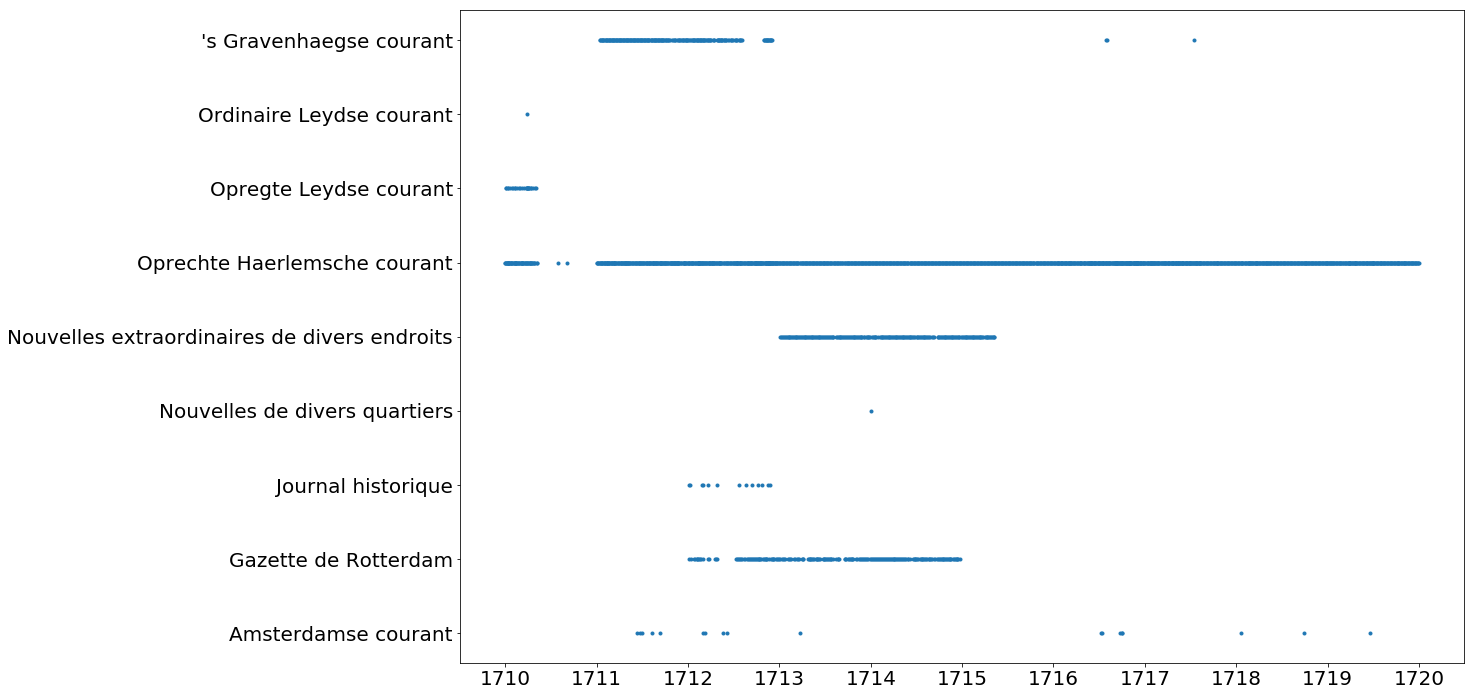

In [3]:
import matplotlib.pyplot as plt

df['period']= pd.to_datetime(df['period'], format='%Y-%m-%d')
df.set_index(df['period'],inplace=True)
plt.figure(figsize=(18, 12))
plt.rcParams.update({'font.size': 20})

plt.plot(df['period'], df['name'], '.')

# What newspaper titles are in this zip file?

In [4]:
list(df.name.unique())


['Amsterdamse courant',
 'Gazette de Rotterdam',
 'Journal historique',
 'Nouvelles de divers quartiers',
 'Nouvelles extraordinaires de divers endroits',
 'Oprechte Haerlemsche courant',
 'Opregte Leydse courant',
 'Ordinaire Leydse courant',
 "'s Gravenhaegse courant"]

In [5]:
import xml.etree.ElementTree as ET  
from langdetect import detect
from pattern.nl import sentiment


# For now we'll not use the complete set,
# parts are in Dutch and some in French, 
# We'll use these selected newpaper titles:

mask = ((df['name'] == "'s Gravenhaegse courant") | 
        (df['name'] == "Amsterdamse courant") |
        (df['name'] == "Oprechte Haerlemsche courant") |
        (df['name'] == "Ordinaire Leydse courant")
       )
wanted_paths = [BASE_PATH + os.sep + f[2:] for f in list(df[mask]["path"])]

# If you want to use all, uncomment the next line.

# wanted_paths = [BASE_PATH + os.sep + f[2:] for f in list(df["path"])]

article_strings = [] # Store all article texts in a list().

for path in wanted_paths:
    # A newspaper 'issue' consists of multiple articles,
    # here we read all of it into a long list.
    #
    # You could apply a fiter for article headings and contents here,
    # Look into one of the _articletext.xml files to get an idea of
    # the structure.
        
    text_files = [path + os.sep + f for f in os.listdir(path) if f.endswith('_articletext.xml')]
    
    # If you want to keep track of how many articles there are per 'issue', 
    # this is an example:
    
    # article_count.append(len(text_files))
    
    for file_name in text_files:
        # Read the XML file using lxml parser.
        tree = ET.parse(file_name)
        for item in tree.iter():
            if item.text and item.text.strip():
                
                # Here we could analyze each peace of text,
                # to see weather it is dutch or french.
                # if detect(item.text) == 'nl':
                
                # For now we'll jus add them all to list().
                article_strings.append(item.text)
                
#df.append(pd.DataFrame(article_count, lang_list, columns=['num_articles', 'lang_list']))

# Using sentiment for splitting the text into, positive and negative

In [6]:
## Negative first

# Here we use pattern's sentiment analysis component,
# to quickly assess if an article is negative.

dirt = [a for a in article_strings if sentiment(a)[0] < -0.1]

# The list() dirt only contains articles with negative sentiment.

word_list = {}
sentences = []

for article in dirt:
    article = article.replace('. ', ' ').replace('.',' ').strip()
    
    sent = []
    
    for word in article.split(' '):
        if word.strip() and word.strip()[0].isalpha():
            if not word in word_list:
                word_list[word] = 0
            else:
                word_list[word] += 1
            if len(word) > 3 and not word in stopwords:
                sent.append(word)
    
    sentences.append(sent)
            
print([(w,word_list[w]) for w in word_list if word_list[w] > 11 and w[0].isupper() and len(w) >3 and not w.lower() in stopwords])
neg = set([w for w in word_list if word_list[w] > 11 and w[0].isupper() and len(w) >3 and not w.lower() in stopwords])

[('Juny', 60), ('Minifter', 28), ('Genua', 17), ('Heden', 23), ('Lord', 32), ('Majt', 30), ('July', 48), ('Huys', 31), ('Minifters', 29), ('Nederlanden', 16), ('Hertog', 127), ('Secretaris', 29), ('Holland', 38), ('Envoyé', 16), ('Giaef', 30), ('Baron', 48), ('Heer', 168), ('Weenen', 27), ('Konings', 13), ('Karel', 15), ('Koning', 198), ('Leger', 59), ('Geallieerden', 27), ('Prins', 109), ('Sweedfe', 14), ('Saxen', 15), ('Augufty', 23), ('Heet', 36), ('Sondag', 17), ('Italien', 14), ('Woensdag', 26), ('Donderdag', 21), ('Hamburg', 28), ('Koningin', 71), ('Gravenhage', 26), ('Schepen', 89), ('Schipper', 23), ('Maendag', 21), ('Frans', 16), ('Willem', 13), ('Capiteyn', 12), ('Heeren', 81), ('Staten', 73), ('Stad', 207), ('Kerk', 17), ('Gedeputeerden', 50), ('Brieven', 49), ('January', 45), ('Turken', 14), ('Capt', 15), ('London', 19), ('Graef', 160), ('Marquis', 44), ('Generael', 85), ('Gouverneur', 36), ('Vlaenderen', 16), ('Regeering', 15), ('Engeland', 34), ('Raed', 65), ('Baton', 18)

# Using word2vec to get an idea of the corpus

In [7]:
from gensim.models import word2vec
from sklearn.decomposition import PCA

In [8]:
# Here we feed the negative sentences into word2vec.
#
# https://en.wikipedia.org/wiki/Word2vec
#

model = word2vec.Word2Vec(sentences, size=100, window=5, min_count=20, workers=4)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


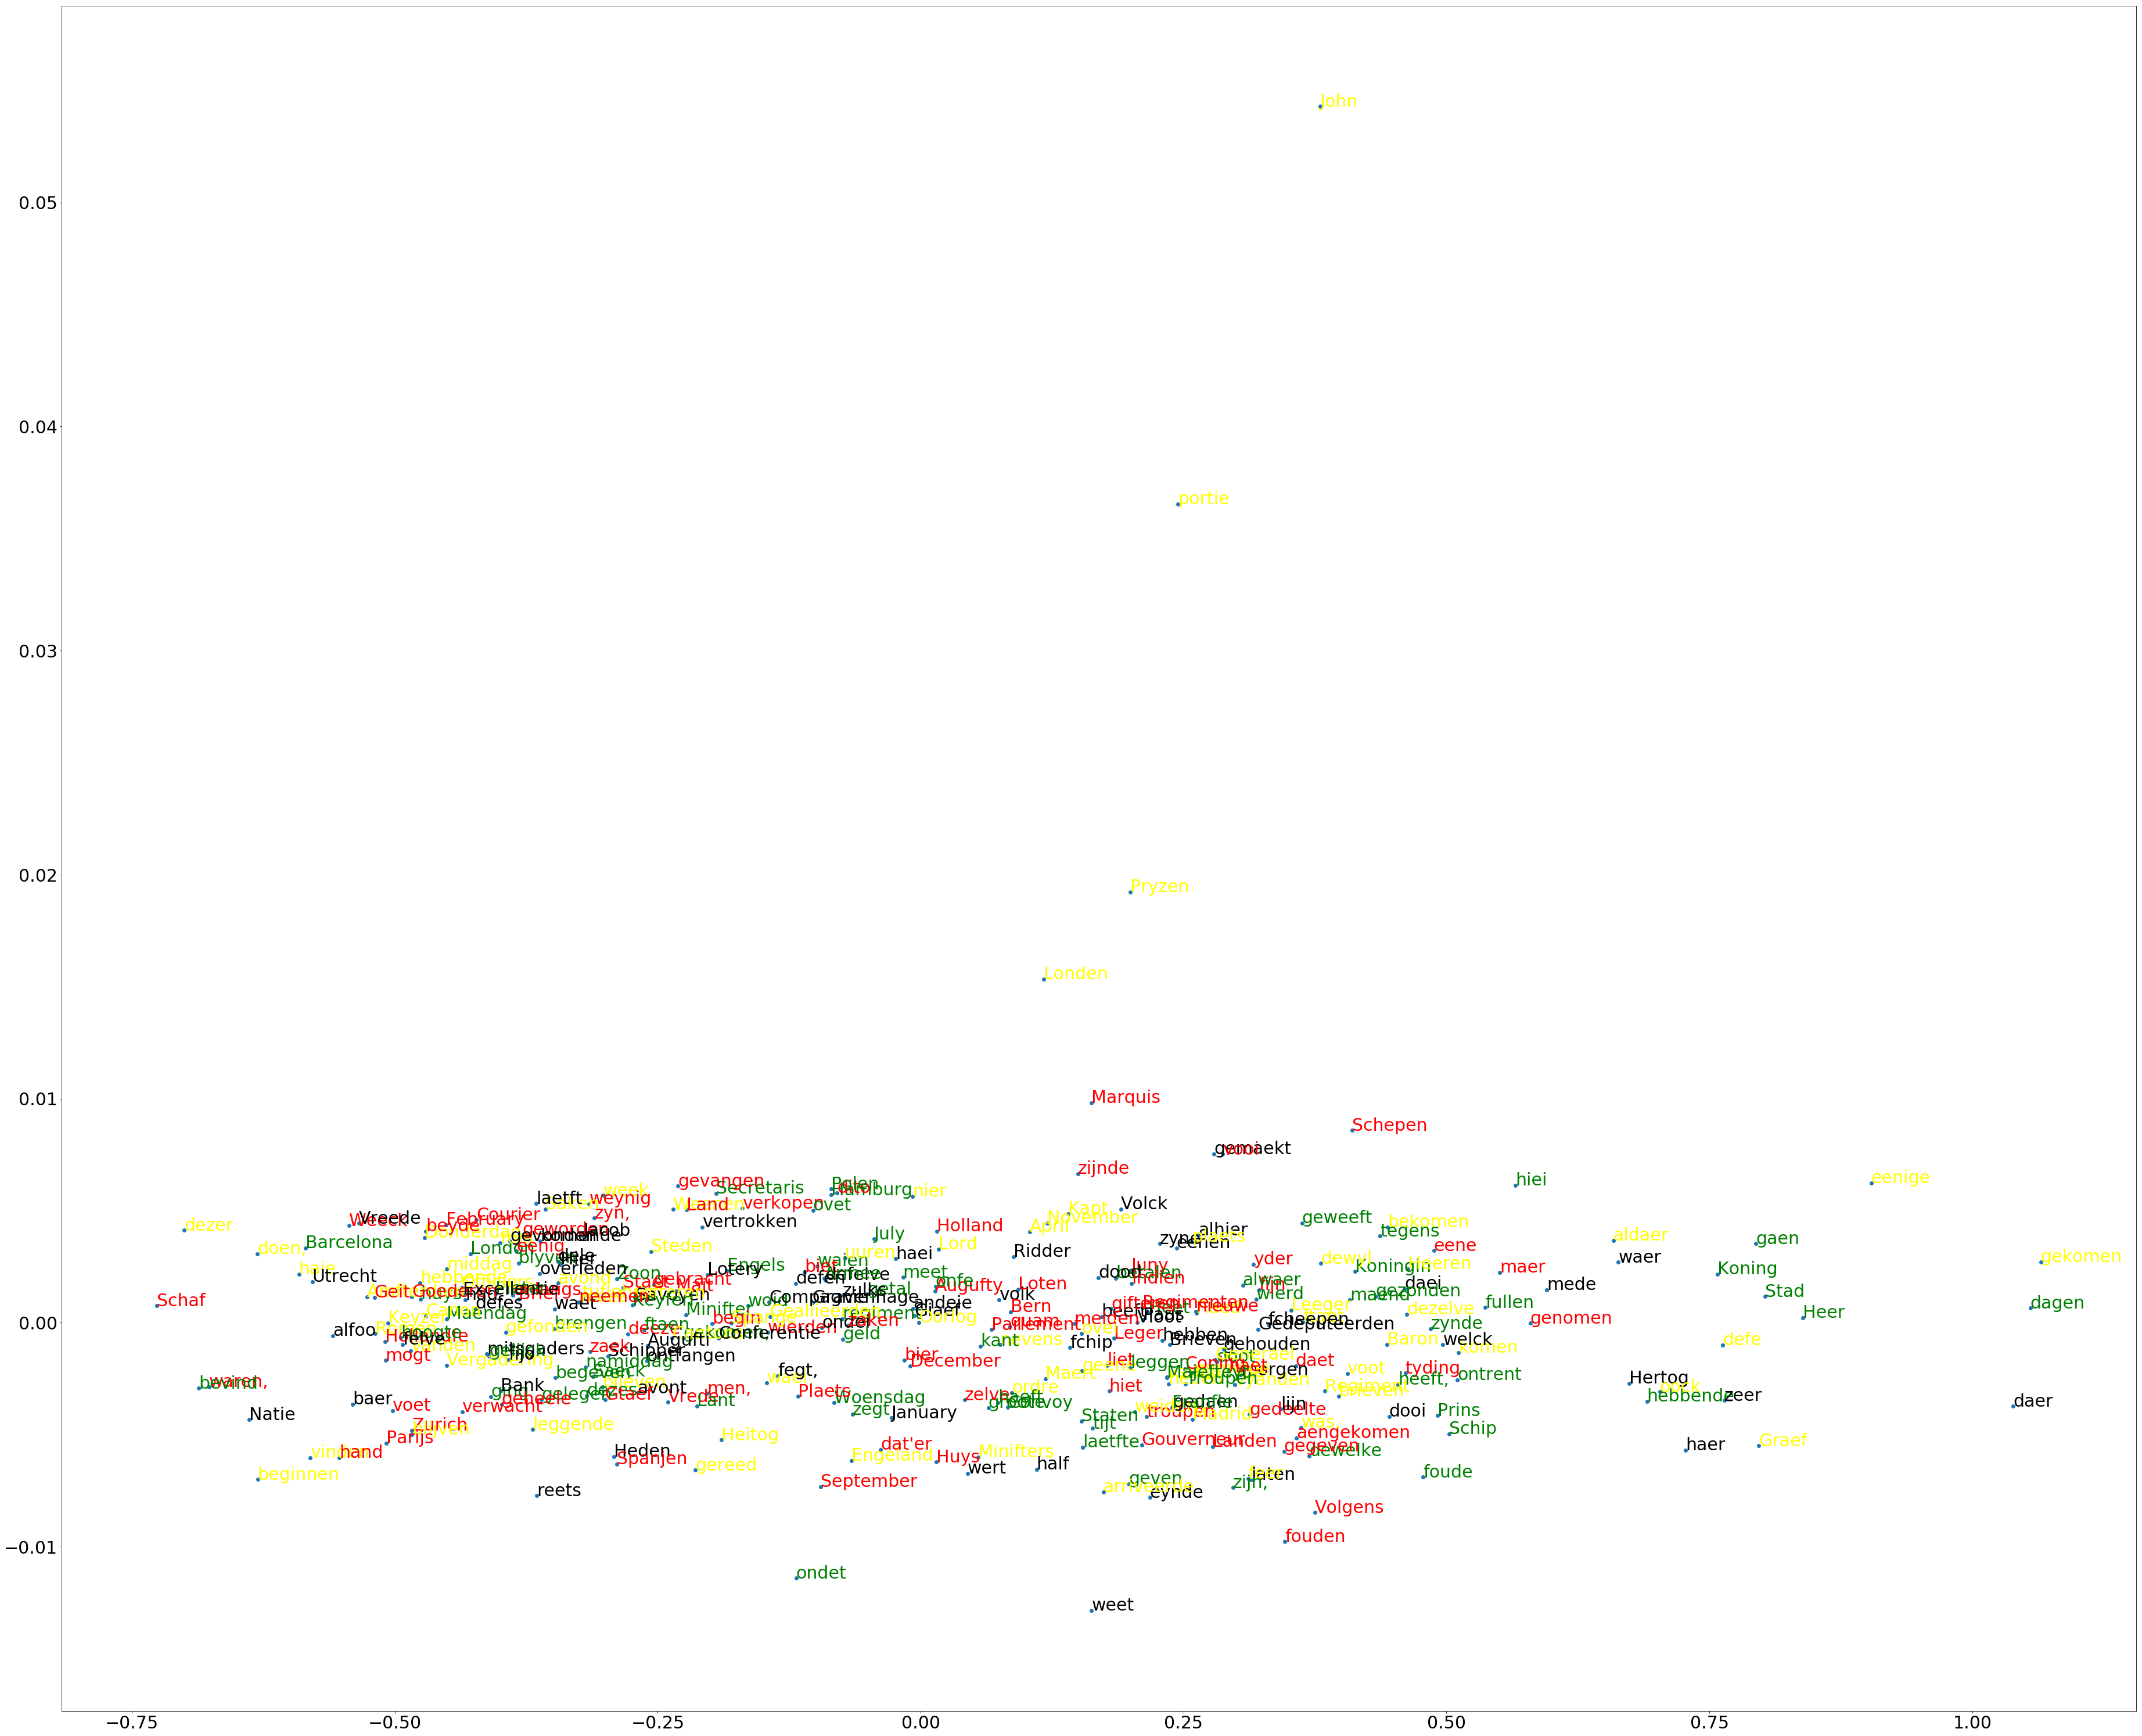

In [9]:
# In order to make a visual representation of the word2vec model,
# we'll have to reduce the number of axis in the model, often PCA is used.

# https://sebastianraschka.com/faq/docs/lda-vs-pca.html

import matplotlib.pyplot as plt

# fit a 2d PCA model to the vectors
X = model[model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)

# create a scatter plot of the projection
plt.figure(figsize=(64, 54))
plt.rcParams.update({'font.size': 30})
plt.scatter(result[:, 0], result[:, 1])

words = list(model.wv.vocab)

import random

for i, word in enumerate(words):
    c = random.choice(['red', 'green', 'yellow', 'black'])
    plt.annotate(word, xy=(result[i, 0], result[i, 1]), color=c)
plt.show()

In [10]:
## Now we will do the same for positive news.
dirt = [a for a in article_strings if sentiment(a)[0] > 0.1]

word_list = {}
sentences = []
for article in dirt:
    article = article.replace('. ', ' ').replace('.',' ').strip()
    
    sent = []
    
    for word in article.split(' '):
        if word.strip() and word.strip()[0].isalpha():
            if not word in word_list:
                word_list[word] = 0
            else:
                word_list[word] += 1
            #if not word.lower() in stopwords:
            if len(word) > 3 and not word in stopwords:
                sent.append(word)
    
    sentences.append(sent)
                
            
print([(w,word_list[w]) for w in word_list if word_list[w] > 300 and w[0].isupper() and len(w) >3 and not w.lower() in stopwords])
pos = set([w for w in word_list if word_list[w] > 300 and w[0].isupper() and len(w) >3 and not w.lower() in stopwords])

[('Koning', 2288), ('Vorft', 583), ('Amfterdam', 1904), ('July', 1677), ('Gouda', 309), ('Frans', 480), ('Heer', 7939), ('Woensdag', 1486), ('Rotterdam', 1237), ('Huys', 3124), ('Land', 1075), ('Goederen', 1220), ('Regenten', 431), ('Willem', 929), ('Nieuwe', 394), ('Weenen', 1249), ('Dingsdag', 1111), ('Prins', 4271), ('Savoyen', 866), ('Milaen', 320), ('Venetien', 467), ('Maendag', 1364), ('Keyfer', 1656), ('Juny', 1761), ('Heeten', 471), ('Hertog', 5550), ('Minifters', 1489), ('Admirael', 441), ('Graef', 6450), ('Generael', 3815), ('Cadogan', 360), ('Geallieerden', 613), ('Major', 827), ('Bergen', 338), ('Namen', 386), ('Congres', 548), ('Heeren', 4451), ('Envoyé', 780), ('Saxen', 633), ('Heet', 1610), ('Baton', 634), ('Giaef', 493), ('Capt', 733), ('Thomas', 1002), ('Romen', 485), ('Napels', 491), ('Onfe', 453), ('Raed', 2887), ('Italien', 552), ('Madrid', 796), ('Marquis', 1383), ('Staet', 1236), ('Duytfe', 304), ('Beyeren', 389), ('Doorl', 496), ('Pieter', 1486), ('Makelaers,', 3

/usr/lib/python3/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


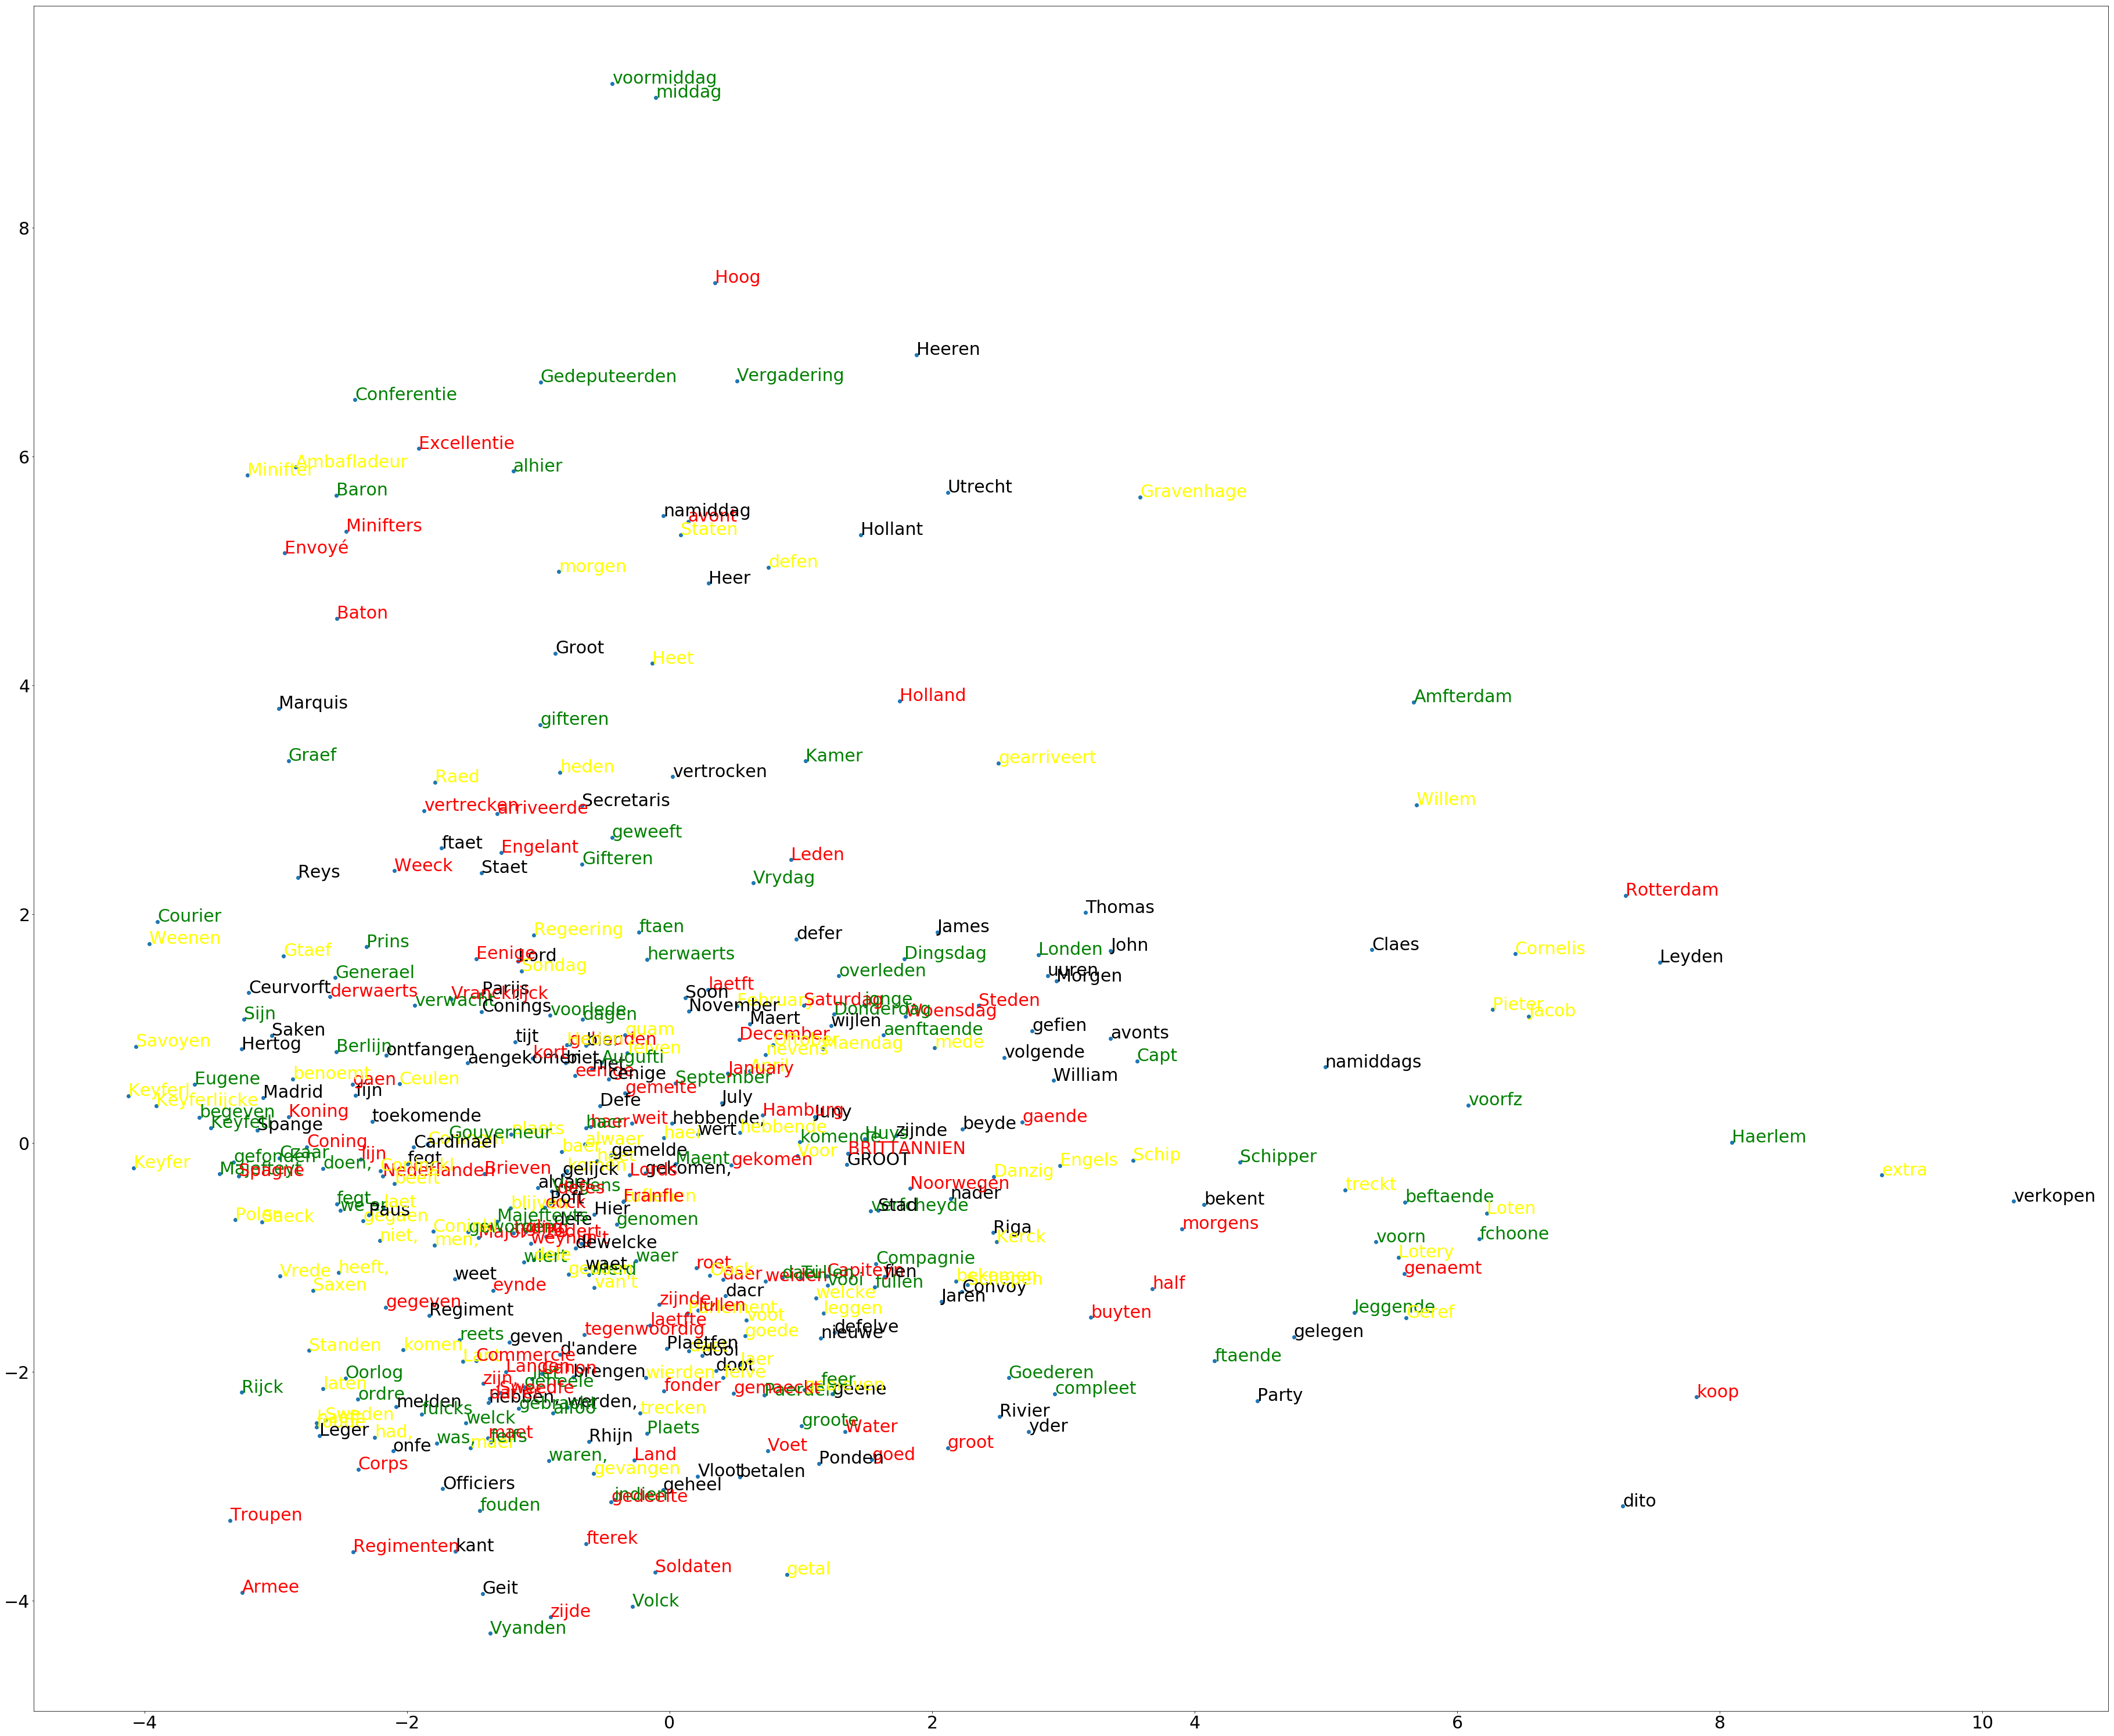

In [11]:
import matplotlib.pyplot as plt

model = word2vec.Word2Vec(sentences, size=100, window=5, min_count=625, workers=4)


# fit a 2d PCA model to the vectors
X = model[model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)

# create a scatter plot of the projection
plt.figure(figsize=(64, 54))
plt.rcParams.update({'font.size': 30})
plt.scatter(result[:, 0], result[:, 1])

words = list(model.wv.vocab)

import random

for i, word in enumerate(words):
    c = random.choice(['red', 'green', 'yellow', 'black'])
    plt.annotate(word, xy=(result[i, 0], result[i, 1]), color=c)
plt.show()

# Explore, visualize more!

In [15]:
from wordcloud import WordCloud


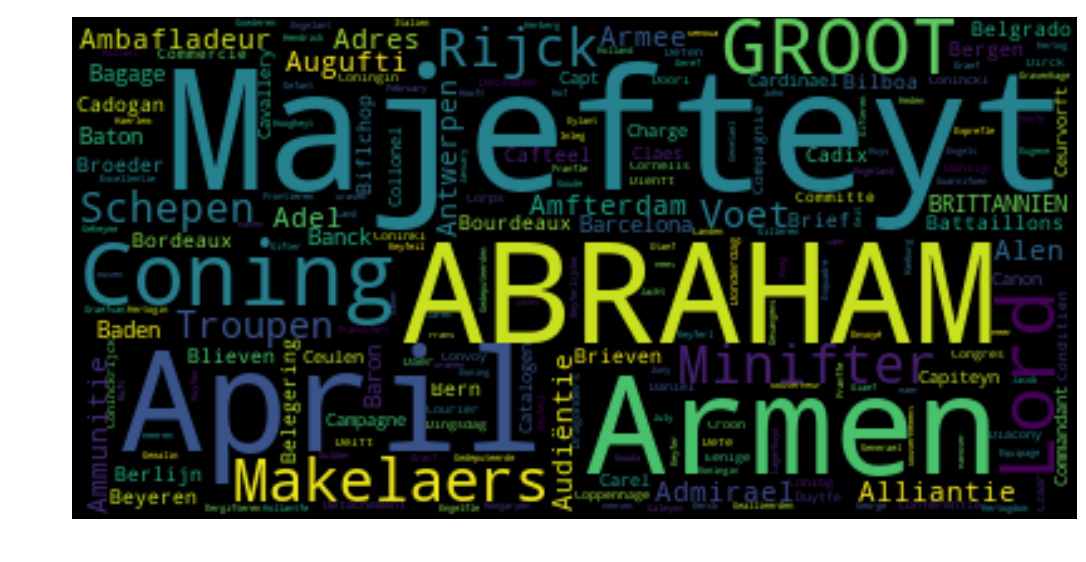

In [21]:
# Positive only
wordcloud = WordCloud().generate(str([w + " " for w in sorted(pos)]))
                                                      
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 16))
plt.axis("off")

plt.imshow(wordcloud, interpolation='bilinear')


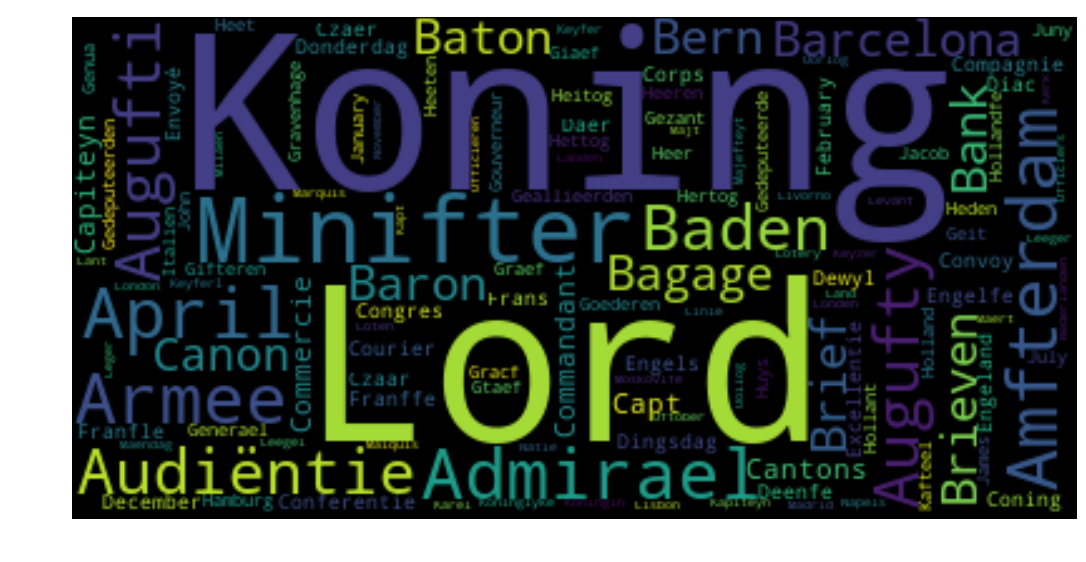

In [22]:
# Negative only
wordcloud = WordCloud().generate(str([w + " " for w in sorted(neg)]))
                                                      
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 16))
plt.axis("off")

plt.imshow(wordcloud, interpolation='bilinear')


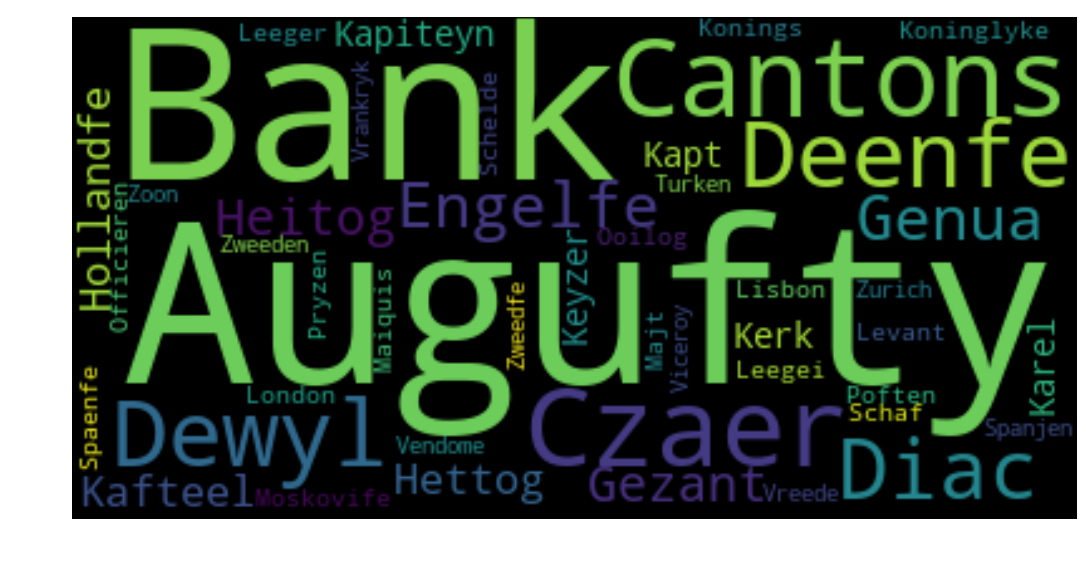

In [24]:
# Negative scored sentices - pos scored

wordcloud = WordCloud().generate(str([w + " " for w in sorted(neg-pos)]))
                                                      
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 16))
plt.axis("off")

plt.imshow(wordcloud, interpolation='bilinear')



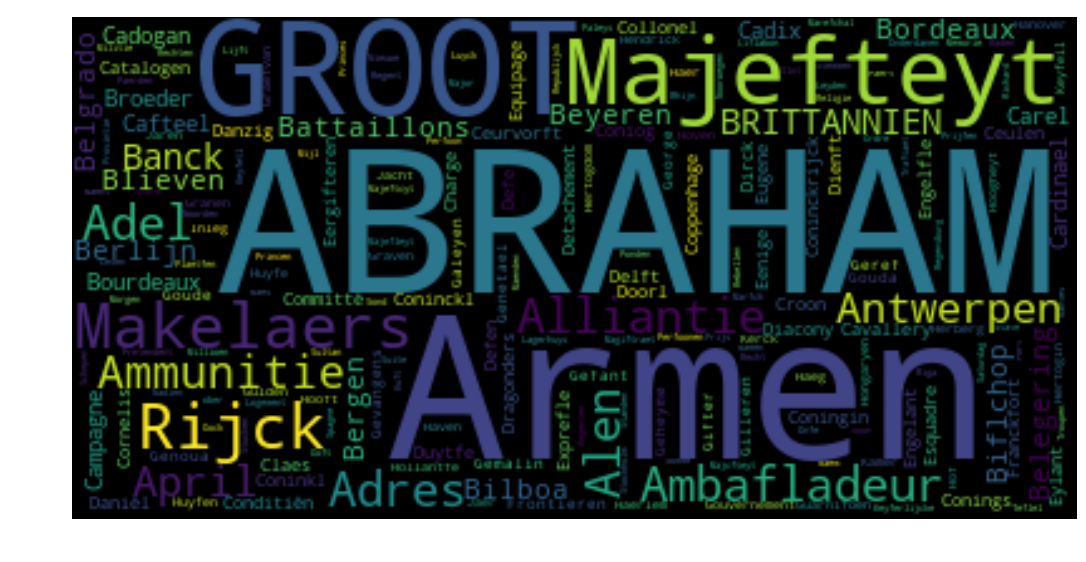

In [25]:
wordcloud = WordCloud().generate(str([w + " " for w in sorted(pos-neg)]))
                                                      
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 16))
plt.axis("off")

plt.imshow(wordcloud, interpolation='bilinear')
